# Adversarial Attack

In [171]:
from keras.applications.inception_v3 import InceptionV3, decode_predictions
from keras.applications.inception_v3 import preprocess_input
import tensorflow as tf
import keras
import cv2
import matplotlib.pyplot as plt
import numpy as np
from keras import backend as K
from keras.preprocessing import image

def load_image(path):
    im = cv2.imread(path)
    im = cv2.cvtColor(im, cv2.COLOR_BGR2RGB)
    im = cv2.resize(im, (299, 299))
    
    return im

def preprocess_image(im):
    im = preprocess_input(im)
    im = np.expand_dims(im, axis = 0)
    
    return im

def denormalise(im):
    im/=2
    im+=0.5
    im*=255
    
    return im.astype(np.uint8)

%matplotlib inline

In [172]:
iv3 = InceptionV3()

In [173]:
original_image = load_image("water_bottle.jpg")
hacked_image = load_image("hacked_water.png")

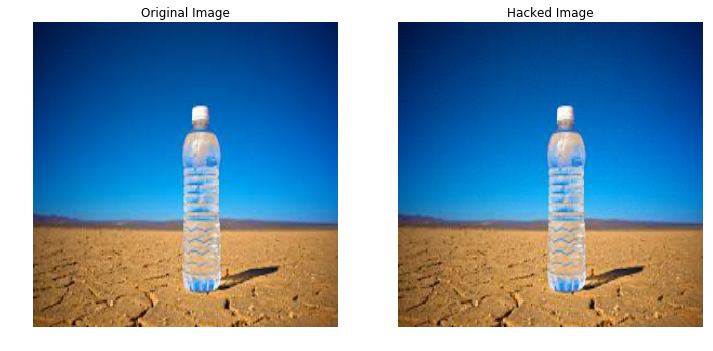

In [214]:
fig, axs = plt.subplots(1, 2, figsize=(12, 10))

axs[0].set_title("Original Image")
axs[0].imshow(original_image)
axs[0].axis("off")
axs[1].set_title("Hacked Image")
axs[1].imshow(hacked_image)
axs[1].axis("off")
plt.show()

In [215]:
decode_predictions(iv3.predict(preprocess_image(original_image)), top=1)[0][0][1]

'water_bottle'

In [216]:
decode_predictions(iv3.predict(preprocess_image(hacked_image)), top=1)[0][0][1]

'beer_glass'

### Explanation

In [178]:
im = preprocess_image(original_image)
inp_layer = iv3.layers[0].input
out_layer = iv3.layers[-1].output

target_class = 441
loss = out_layer[0, target_class]
grad = K.gradients(loss, inp_layer)[0]
optimize_gradient = K.function([inp_layer, K.learning_phase()], [grad, loss])
adv = np.copy(im)

In [179]:
cost = 0.0

max_pert = im + 0.01
min_pert = im - 0.01

while cost < 0.95:
    gr, cost = optimize_gradient([adv, 0])
    adv += gr
    adv = np.clip(adv, min_pert, max_pert)
    adv = np.clip(adv, -1 , 1)
    print("Target Cost", cost)

Target Cost 9.625923e-05
Target Cost 9.7882265e-05
Target Cost 9.952366e-05
Target Cost 0.000101184334
Target Cost 0.000102900216
Target Cost 0.00010468769
Target Cost 0.00010653451
Target Cost 0.00010842473
Target Cost 0.00011031601
Target Cost 0.00011219311
Target Cost 0.000114089424
Target Cost 0.00011601654
Target Cost 0.00011797344
Target Cost 0.00011998269
Target Cost 0.00012203334
Target Cost 0.00012410183
Target Cost 0.00012623881
Target Cost 0.0001284148
Target Cost 0.00013060054
Target Cost 0.00013279462
Target Cost 0.00013500315
Target Cost 0.00013725493
Target Cost 0.00013958936
Target Cost 0.00014198948
Target Cost 0.00014441657
Target Cost 0.00014683149
Target Cost 0.00014926479
Target Cost 0.00015172313
Target Cost 0.00015420913
Target Cost 0.00015675448
Target Cost 0.00015933307
Target Cost 0.00016197073
Target Cost 0.00016462005
Target Cost 0.00016728544
Target Cost 0.00016997385
Target Cost 0.00017271847
Target Cost 0.00017552511
Target Cost 0.00017837528
Target Cost 

In [180]:
decode_predictions(iv3.predict(adv))

[[('n02823750', 'beer_glass', 0.99668425),
  ('n03916031', 'perfume', 0.00064448564),
  ('n02815834', 'beaker', 0.00048680636),
  ('n02823428', 'beer_bottle', 0.00036049535),
  ('n03443371', 'goblet', 0.0003140619)]]

In [181]:
im = denormalise(im.reshape(im.shape[1], im.shape[2], im.shape[3]))
adv = denormalise(adv.reshape(adv.shape[1], adv.shape[2], adv.shape[3]))

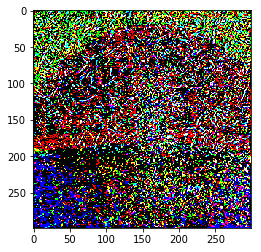

In [182]:
plt.imshow(im-adv)

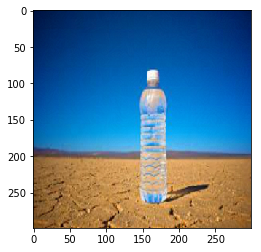

In [183]:
plt.imshow(adv)

In [184]:
import matplotlib

matplotlib.image.imsave('hacked_water.png', adv)